## Bayesian Optimization with Heteroskedastic Noise GP Modeling
In this tutorial we demonstrate the use of Xopt to preform Bayesian Optimization on a
 simple test problem. The problem exibits non-uniform (heteroskedastic) noise which
 we account for in the GP model. This requires explicit specification of the
 measurement variance.

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [1]:
from xopt.vocs import VOCS
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

## Specifying measurement variance
We specify variance in the objective function by appending `_var` to it. This info
will collected by the model constructor to make a heteroskedastic model.

In [2]:
# define a test function to optimize
# the test function also returns an estimation of the variance, which is
# used to create a Heteroskedastic noise model for the gp
import numpy as np

def sin_function(input_dict):
    return {"f": np.sin(input_dict["x"]), "f_var":0.001*input_dict["x"]}

## Create Xopt objects
Create the evaluator to evaluate our test function and create a generator that uses
the Upper Confidence Bound acquisition function to perform Bayesian Optimization.

In [3]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

evaluator = Evaluator(function=sin_function)
generator = UpperConfidenceBoundGenerator(vocs=vocs)
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate() to generate + evaluate 3 initial points
X.random_evaluate(4)

# inspect the gathered data
X.data

,x,f,f_var,xopt_runtime,xopt_error
0,3.364549,-0.221114,0.003365,4.334026e-06,False
1,4.708569,-0.999993,0.004709,1.541979e-06,False
2,2.781821,0.352060,0.002782,1.125009e-06,False
3,2.959684,0.180907,0.002960,7.920025e-07,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

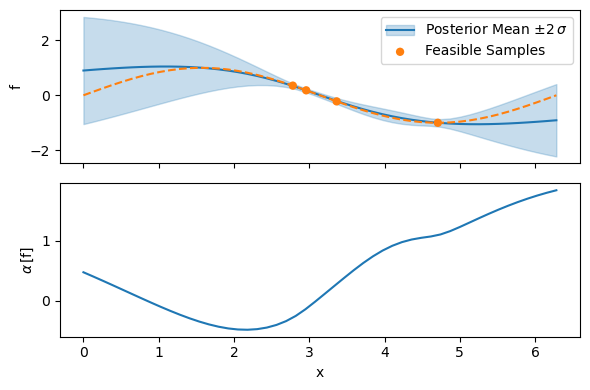

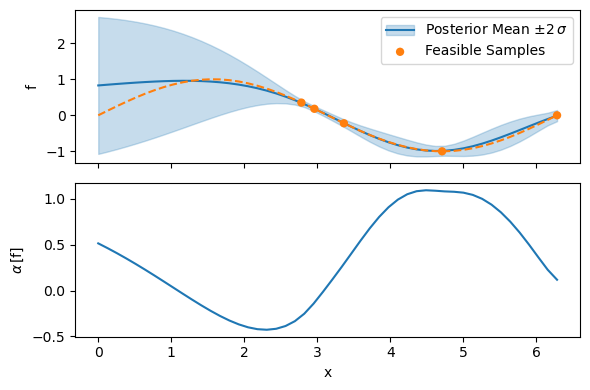

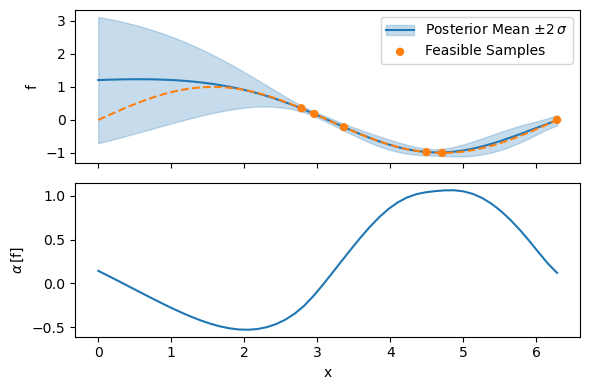

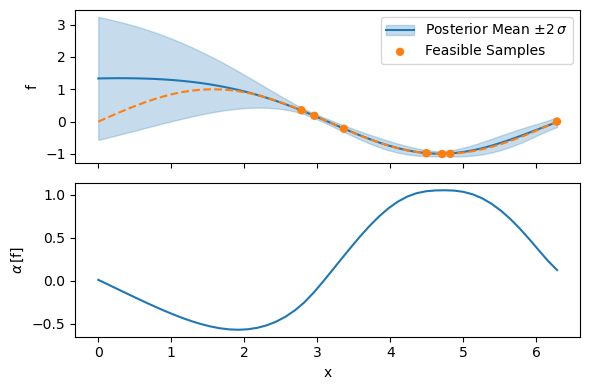

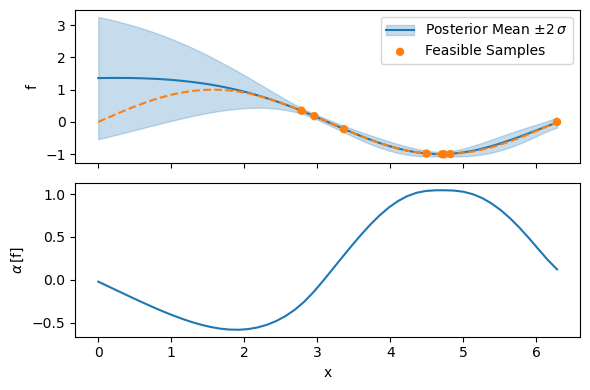

In [5]:
import torch

n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # visualize model
    fig, ax = X.generator.visualize_model(n_grid=len(test_x))
    
    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f, "C1--")

    # do the optimization step
    X.step()

In [6]:
# access the collected data
X.data

,x,f,f_var,xopt_runtime,xopt_error
0,3.364549,-2.211141e-01,0.003365,4.334026e-06,False
1,4.708569,-9.999927e-01,0.004709,1.541979e-06,False
2,2.781821,3.520602e-01,0.002782,1.125009e-06,False
3,2.959684,1.809073e-01,0.002960,7.920025e-07,False
4,6.283185,-2.449294e-16,0.006283,4.250003e-06,False
5,4.494135,-9.762771e-01,0.004494,4.542002e-06,False
6,4.822862,-9.939041e-01,0.004823,4.208996e-06,False
7,4.737439,-9.996863e-01,0.004737,7.209019e-06,False
8,4.698162,-9.998988e-01,0.004698,3.958005e-06,False


## Getting the optimization result
To get the best point (without evaluating it) we ask the generator to
predict the optimum based on the posterior mean.

In [7]:
X.generator.get_optimum()

,x
0,4.683196


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [8]:
X.generator.dict()

{'model': ModelListGP(
   (models): ModuleList(
     (0): XoptHeteroskedasticSingleTaskGP(
       (likelihood): _GaussianLikelihoodBase(
         (noise_covar): HeteroskedasticNoise(
           (noise_model): SingleTaskGP(
             (likelihood): GaussianLikelihood(
               (noise_covar): HomoskedasticNoise(
                 (noise_prior): SmoothedBoxPrior()
                 (raw_noise_constraint): GreaterThan(1.000E-04)
               )
             )
             (mean_module): ConstantMean()
             (covar_module): ScaleKernel(
               (base_kernel): MaternKernel(
                 (lengthscale_prior): GammaPrior()
                 (raw_lengthscale_constraint): Positive()
               )
               (outputscale_prior): GammaPrior()
               (raw_outputscale_constraint): Positive()
             )
             (outcome_transform): Log()
             (input_transform): Normalize()
           )
           (_noise_constraint): GreaterThan(1.000E-04)
      